In [1]:
import jax
from jax import numpy as jnp
from jax import random

In [8]:
def test_H_once(H):
    N = 128
    a_cov = jnp.eye(H)*0.5
    lam = 0.01

    def dynamic_fn(x, action):
        x = jnp.clip(x + 0.3*x**2 + 0.4 * jnp.clip(action, -1.0, 1.0), -2, 2)
        return x
    
    def reward_fn(t, x):
        x_tar = jnp.sin(0.6*t)
        reward = 1.0-jnp.abs(x - x_tar)
        return reward

    def get_next_a_mean(t, x, a_mean, rng):
        # shift a_mean to the left by 1 and append the last element
        a_mean = jnp.concatenate([a_mean[1:], a_mean[-1:]])

        rng_act, rng = random.split(rng)
        # sample actions with a_mean and a_cov
        a_sampled = jax.vmap(lambda rng: random.multivariate_normal(rng, a_mean, a_cov))(random.split(rng, N)) # (N, H)

        def rollout_fn(carry, action):
            t, x = carry
            x = dynamic_fn(x, action)
            t = t + 1
            reward = reward_fn(t, x)
            return (t, x), reward

        xx = jnp.repeat(x, N)
        tt = jnp.repeat(t, N)
        _, reward = jax.lax.scan(rollout_fn, (tt, xx), a_sampled.T)

        cost = -jnp.sum(reward, axis=0)
        cost_exp = jnp.exp(-(cost-jnp.min(cost)) / lam)
        weight = cost_exp / jnp.sum(cost_exp)

        # get smallest N//4 cost mask
        # cost_normed = cost - jnp.min(cost)
        # top_k_mask = (cost_normed < jnp.sort(cost_normed)[N//4])
        # cost_normed_masked = jnp.where(top_k_mask, cost_normed, 0.0)
        # weight = cost_normed_masked / jnp.sum(cost_normed_masked)

        a_mean = jnp.sum(a_sampled * weight[:, None], axis=0)

        return a_mean, rng

    def step_env(carry, unused):
        t, x, a_mean, rng = carry
        a_mean, rng = get_next_a_mean(t, x, a_mean, rng)
        action = a_mean[0]
        reward = reward_fn(t, x)
        x = dynamic_fn(x, action)
        t = t + 1
        return (t, x, a_mean, rng), (x, reward)


    def run_exp_once(rng):
        x0 = 1.0
        t0 = 0
        a_mean = jnp.zeros(H)
        carry = (t0, x0, a_mean, rng)
        _, (x, reward) = jax.lax.scan(step_env, carry, jnp.arange(30))
        return reward.mean()

    rng = random.PRNGKey(0)
    # run experiment for 1024 times
    rewards = jax.vmap(jax.jit(run_exp_once))(random.split(rng, 4096))

    return rewards.mean(), rewards.std()

In [9]:
with jax.disable_jit():
    test_H_once(1)

XlaRuntimeError: INTERNAL: cuSolver internal error

In [6]:
Hs = jnp.power(2, jnp.arange(0, 8))
means = []
stds = []
for H in Hs:
    mean, std = test_H_once(H)
    means.append(mean)
    stds.append(std)

XlaRuntimeError: INTERNAL: cuSolver internal error

In [3]:
# plot results with error bars
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.errorbar(jnp.log2(Hs), means, yerr=stds, fmt='o')
plt.xlabel('log horizon')
plt.ylabel('average reward')

NameError: name 'Hs' is not defined

I0000 00:00:1696347823.014412  110930 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


(16,) ()
(16,) ()
(16,) ()


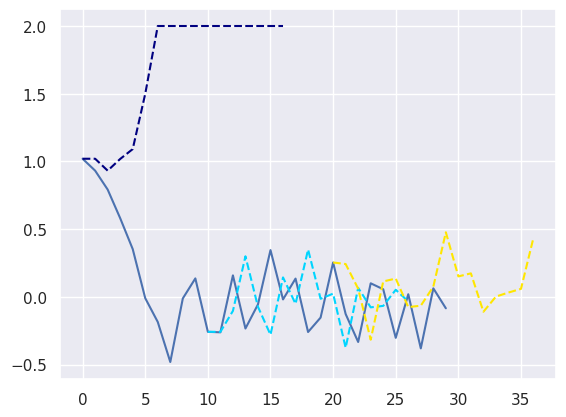

In [4]:
N = 128
H = 2**4
a_cov = jnp.eye(H)*0.5
lam = 0.01

def dynamic_fn(x, action):
    x = jnp.clip(x + 0.3*x**2 + 0.4 * jnp.clip(action, -1.0, 1.0), -2, 2)
    return x

def reward_fn(x):
    reward = 1.0-jnp.abs(x)
    return reward

def get_next_a_mean(x, a_mean, rng):
    # shift a_mean to the left by 1 and append the last element
    a_mean = jnp.concatenate([a_mean[1:], a_mean[-1:]])

    rng_act, rng = random.split(rng)
    # sample actions with a_mean and a_cov
    a_sampled = jax.vmap(lambda rng: random.multivariate_normal(rng, a_mean, a_cov))(random.split(rng, N)) # (N, H)

    def rollout_fn(carry, action):
        x = carry
        x = dynamic_fn(x, action)
        reward = reward_fn(x)
        return x, (reward, x)

    xx = jnp.repeat(x, N)
    _, (reward, x_sampled) = jax.lax.scan(rollout_fn, xx, a_sampled.T)

    cost = -jnp.sum(reward, axis=0)
    cost_exp = jnp.exp(-(cost-jnp.min(cost)) / lam)
    weight = cost_exp / jnp.sum(cost_exp)

    # get smallest 25% costs mask
    # cost_normed = (cost - jnp.min(cost)) / (jnp.max(cost) - jnp.min(cost))
    # top_k_mask = cost_normed < jnp.percentile(cost_normed, 25)
    # cost_normed_masked = jnp.where(top_k_mask, cost_normed, 0.0)
    # weight = cost_normed_masked / jnp.sum(cost_normed_masked)

    a_mean = jnp.sum(a_sampled * weight[:, None], axis=0)

    x_mean = jnp.sum(x_sampled.T * weight[:, None], axis=0)

    return a_mean, rng, x_sampled, x_mean

def step_env(carry, unused):
    x, a_mean, rng = carry
    a_mean, rng, x_sampled, x_mean = get_next_a_mean(x, a_mean, rng)
    action = a_mean[0]
    reward = reward_fn(x)
    x = dynamic_fn(x, action)
    return (x, a_mean, rng), (x, reward, x_sampled, x_mean)

x0 = 1.0
a_mean = jnp.zeros(H)
carry = (x0, a_mean, random.PRNGKey(0))
_, (x, reward, x_sampled, x_mean) = jax.lax.scan(step_env, carry, jnp.arange(30))

plt.plot(x)
for i in range(0, 30, 10):
    t = jnp.arange(i, i+H+1)
    mean = jnp.concatenate([jnp.array([x[i]]), x_mean[i]])
    plt.plot(t, mean, '--', alpha=1.0, color=plt.cm.jet(i/30))
    # for j in range(N):
    #     sampled = x_sampled[i, :, j]
    #     sampled = jnp.concatenate([jnp.array([x[i]]), sampled])
    #     # set color related to i
    #     plt.plot(t, sampled, '--', alpha=0.5, color=plt.cm.jet(i/30))

In [ ]:
x_mean.shape